In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy, sparse_categorical_crossentropy
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
%cd '/content/gdrive/My Drive/Datasets/Plant-Disease-Dataset/train_preprocessed/'

/content/gdrive


In [ ]:
%ls

 Apple___Apple_scab/
 Apple___Black_rot/
 Apple___Cedar_apple_rust/
 Apple___healthy/
 Blueberry___healthy/
'Cherry_(including_sour)___healthy'/
'Cherry_(including_sour)___Powdery_mildew'/
'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'/
'Corn_(maize)___Common_rust_'/
'Corn_(maize)___healthy'/
'Corn_(maize)___Northern_Leaf_Blight'/
 Grape___Black_rot/
'Grape___Esca_(Black_Measles)'/
 Grape___healthy/
'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'/
'Orange___Haunglongbing_(Citrus_greening)'/
 Peach___Bacterial_spot/
 Peach___healthy/
 Pepper,_bell___Bacterial_spot/
 Pepper,_bell___healthy/
 Potato___Early_blight/
 Potato___healthy/
 Potato___Late_blight/
 Raspberry___healthy/
 Soybean___healthy/
 Squash___Powdery_mildew/
 Strawberry___healthy/
 Strawberry___Leaf_scorch/
 Tomato___Bacterial_spot/
 Tomato___Early_blight/
 Tomato___healthy/
 Tomato___Late_blight/
 Tomato___Leaf_Mold/
 Tomato___Septoria_leaf_spot/
'Tomato___Spider_mites Two-spotted_spider_mite'/
 Tomato___Target_Spot/
 T

In [ ]:
params = {
          "ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"
          }
plt.rcParams.update(params)

In [ ]:
PATH = '/content/gdrive/My Drive/Datasets/Plant-Disease-Dataset/'

In [ ]:
train_dir = os.path.join(PATH, 'train')
valid_dir = os.path.join(PATH, 'valid')
test_dir = os.path.join(PATH, 'test')
train_preprocessed_dir = os.path.join(PATH, 'train_preprocessed')
valid_preprocessed_dir = os.path.join(PATH, 'valid_preprocessed')
test_preprocessed_dir = os.path.join(PATH, 'test_preprocessed')

In [ ]:
tht = os.path.join(valid_dir, 'Tomato___healthy')
thtp = os.path.join(valid_preprocessed_dir, 'Tomato___healthy')

In [ ]:
len(os.listdir(thtp))

481

In [ ]:
labels = os.listdir(valid_dir)
labels

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_

In [ ]:
for label in labels:
  path = os.path.join(valid_preprocessed_dir, label)
  os.mkdir(path)

In [ ]:
label_dir = os.path.join(train_dir, labels[0])
img = cv2.imread(label_dir + '/' + os.listdir(label_dir)[11])

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# find the green color
mask_green = cv2.inRange(hsv, (36,0,0), (86,255,255))
# find the brown color
mask_brown = cv2.inRange(hsv, (8, 60, 20), (120, 255, 255))
# find the yellow color in the leaf
mask_yellow = cv2.inRange(hsv, (5, 42, 143), (90, 255, 255))
# find the black color in the leaf
mask_black = cv2.inRange(hsv, (100, 100, 100), (127, 127, 127))


# find any of the three colors(green or brown or yellow) in the image
mask = cv2.bitwise_or(mask_green, mask_brown)
mask = cv2.bitwise_or(mask, mask_yellow)
mask = cv2.bitwise_or(mask, mask_black)
mask = cv2.bitwise_or(mask, mask_white)

# Bitwise-AND mask and original image
res = cv2.bitwise_and(img, img, mask = mask)

blur_img = cv2.GaussianBlur(res, (3, 3), 0)

res_hsv = cv2.cvtColor(blur_img, cv2.COLOR_BGR2HSV)
vectorized_res = res_hsv.reshape((-1,3))
vectorized_res = np.float32(vectorized_res)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 10
attempts = 10

ret, label, center = cv2.kmeans(vectorized_res, K, None, 
                                criteria, attempts, cv2.KMEANS_PP_CENTERS)

center = np.uint8(center)
result = center[label.flatten()]
result_image = result.reshape((res.shape))

B, G, R = cv2.split(blur_img)
output_R = cv2.equalizeHist(R)
output_G = cv2.equalizeHist(G)
output_B = cv2.equalizeHist(B)
output_merge = cv2.merge((output_R, output_G, output_B))

f, axarr = plt.subplots(1, 5)
f.set_size_inches(21.5, 20.5)
axarr[0].imshow(img)
axarr[0].set_title("Original", color = 'w')
axarr[1].imshow(res)
axarr[1].set_title("Masked", color = 'w')
axarr[2].imshow(blur_img)
axarr[2].set_title("Blurred", color = 'w')
axarr[3].imshow(result_image)
axarr[3].set_title("Segmented 1", color = 'w')
axarr[4].imshow(output_merge)
axarr[4].set_title("Segmented 2", color = 'w')

In [ ]:
for classes in os.listdir(valid_dir):
  filename = 0
  print("Working Directory: " + classes)
  for images in os.listdir(valid_dir + '/' + classes):
    # Update filename
    filename += 1
    # Read the image
    img = plt.imread(valid_dir + '/' + classes + '/' + images)
    # Convert image to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # find the green color
    mask_green = cv2.inRange(hsv, (36,0,0), (86,255,255))
    # find the brown color
    mask_brown = cv2.inRange(hsv, (8, 60, 20), (145, 255, 255))
    # find the yellow color in the leaf
    mask_yellow = cv2.inRange(hsv, (5, 42, 143), (145, 255, 255))
    # find the black color in the leaf
    mask_black = cv2.inRange(hsv, (100, 100, 100), (127, 127, 127))

    # find any of the four colors(green or brown or yellow or black) in the image
    mask = cv2.bitwise_or(mask_green, mask_brown)
    mask = cv2.bitwise_or(mask, mask_yellow)
    mask = cv2.bitwise_or(mask, mask_black)

    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(img, img, mask = mask)

    # Gaussian blur with 3x3 kernel
    blur_img = cv2.GaussianBlur(res, (3, 3), 0)

    # Histogram equalization
    B, G, R = cv2.split(blur_img)
    output_R = cv2.equalizeHist(R)
    output_G = cv2.equalizeHist(G)
    output_B = cv2.equalizeHist(B)
    output_merge = cv2.merge((output_R, output_G, output_B))

    # Save the preprocessed image
    if cv2.imwrite(valid_preprocessed_dir + '/' + classes + '/' + str(filename) + '.jpg', output_merge):
      print("Processed Image: " + str(filename))

In [ ]:
print("Working Directory: test")

for images in os.listdir(test_dir + '/' + 'test'):
    # Read the image
  img = plt.imread(test_dir + '/' + 'test' + '/' + images)
    # Convert image to HSV
  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # find the green color
  mask_green = cv2.inRange(hsv, (36,0,0), (86,255,255))
    # find the brown color
  mask_brown = cv2.inRange(hsv, (8, 60, 20), (145, 255, 255))
    # find the yellow color in the leaf
  mask_yellow = cv2.inRange(hsv, (5, 42, 143), (145, 255, 255))
    # find the black color in the leaf
  mask_black = cv2.inRange(hsv, (100, 100, 100), (127, 127, 127))

    # find any of the four colors(green or brown or yellow or black) in the image
  mask = cv2.bitwise_or(mask_green, mask_brown)
  mask = cv2.bitwise_or(mask, mask_yellow)
  mask = cv2.bitwise_or(mask, mask_black)

    # Bitwise-AND mask and original image
  res = cv2.bitwise_and(img, img, mask = mask)

    # Gaussian blur with 3x3 kernel
  blur_img = cv2.GaussianBlur(res, (3, 3), 0)

    # Histogram equalization
  B, G, R = cv2.split(blur_img)
  output_R = cv2.equalizeHist(R)
  output_G = cv2.equalizeHist(G)
  output_B = cv2.equalizeHist(B)
  output_merge = cv2.merge((output_R, output_G, output_B))

    # Save the preprocessed image
  if cv2.imwrite(test_preprocessed_dir + '/' + images, output_merge):
    print("Processed Image: " + images)

In [ ]:
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 

# ret, thresh = cv2.threshold(gray, 0, 255, 
#                             cv2.THRESH_BINARY_INV +
#                             cv2.THRESH_OTSU)

# kernel = np.ones((3, 3), np.uint8)
# closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations = 2)

# # Background area using Dialation 
# bg = cv2.dilate(closing, kernel, iterations = 1) 

# # Finding foreground area 
# dist_transform = cv2.distanceTransform(closing, cv2.DIST_L2, 0)
# ret, fg = cv2.threshold(dist_transform, 0.02 * dist_transform.max(), 255, 0)

In [ ]:
batch_size = 128
epochs = 20
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [ ]:
train_image_generator = ImageDataGenerator(rescale = 1./255)
validation_image_generator = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(batch_size = batch_size,
                                                           directory = train_preprocessed_dir,
                                                           shuffle = True,
                                                           target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode = 'categorical')

Found 70295 images belonging to 38 classes.


In [ ]:
valid_data_gen = validation_image_generator.flow_from_directory(batch_size = batch_size,
                                                              directory = valid_preprocessed_dir,
                                                              target_size = (IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode = 'categorical')

Found 17572 images belonging to 38 classes.


In [ ]:
model = InceptionV3(include_top = False, 
                    weights = 'imagenet', input_shape = (150, 150, 3))
model.trainable = False
for layers in model.layers:
  layers.trainable = False

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# Flatten the output layer to 1 dimension
x = keras.layers.Flatten()(model.output)

# Add a fully connected layer with 1024 hidden units with ReLU activation
x = keras.layers.Dense(1024, activation = 'relu')(x)

# Add a Dropout Layer with dropout rate of 0.2
x = keras.layers.Dropout(0.2)(x)

# Add a final dense layer with Softmax activation for classification
x = keras.layers.Dense(38, activation = 'softmax')(x)

model = Model(model.input, x)

model.compile(optimizer = Adam(lr = 0.0001),
               loss='categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > 0.989:
      print("98.9% accuracy achieved. Aborting training.")
      self.model.stop_training = True

In [ ]:
callbacks = myCallback()
history = model.fit_generator(generator = train_data_gen,
                              steps_per_epoch = train_data_gen.samples // train_data_gen.batch_size,
                              epochs = 20,
                              verbose = 1,
                              callbacks = [callbacks],
                              validation_data = valid_data_gen,
                              validation_steps = valid_data_gen.samples // valid_data_gen.batch_size)

Epoch 1/20
  4/549 [..............................] - ETA: 11:18:49 - loss: 5.1639 - accuracy: 0.0469

In [ ]:
model.save("/content/gdrive/My Drive/Datasets/Plant-Disease-Dataset/model.h5")

In [ ]:
model.fit()

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("/content/gdrive/My Drive/Datasets/Plant-Disease-Dataset/15.4k_images_model.h5")

In [ ]:
from tensorflow import lite

In [ ]:
converter = lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with tf.io.gfile.GFile('/content/gdrive/My Drive/Datasets/Plant-Disease-Dataset/15.4k_lite_model.tflite', 'wb') as f:
  f.write(tflite_model)

(256, 256, 3)


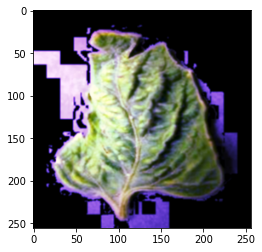

In [ ]:
img = cv2.imread(test_dir + '/test/TomatoYellowCurlVirus4.JPG')

    # Convert image to HSV
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # find the green color
mask_green = cv2.inRange(hsv, (36,0,0), (86,255,255))
    # find the brown color
mask_brown = cv2.inRange(hsv, (8, 60, 20), (145, 255, 255))
    # find the yellow color in the leaf
mask_yellow = cv2.inRange(hsv, (5, 42, 143), (145, 255, 255))
    # find the black color in the leaf
mask_black = cv2.inRange(hsv, (100, 100, 100), (127, 127, 127))

    # find any of the four colors(green or brown or yellow or black) in the image
mask = cv2.bitwise_or(mask_green, mask_brown)
mask = cv2.bitwise_or(mask, mask_yellow)
mask = cv2.bitwise_or(mask, mask_black)

    # Bitwise-AND mask and original image
res = cv2.bitwise_and(img, img, mask = mask)

    # Gaussian blur with 3x3 kernel
blur_img = cv2.GaussianBlur(res, (3, 3), 0)

    # Histogram equalization
B, G, R = cv2.split(blur_img)
output_R = cv2.equalizeHist(R)
output_G = cv2.equalizeHist(G)
output_B = cv2.equalizeHist(B)
output_merge = cv2.merge((output_R, output_G, output_B))

plt.imshow(output_merge)
print(output_merge.shape)